Loading and preprocessing data...
Files loaded successfully. Processing data...
Converting dates...
Extracting hours...
Converting numeric values...
Data preprocessing completed successfully!

Generating visualizations and analysis...


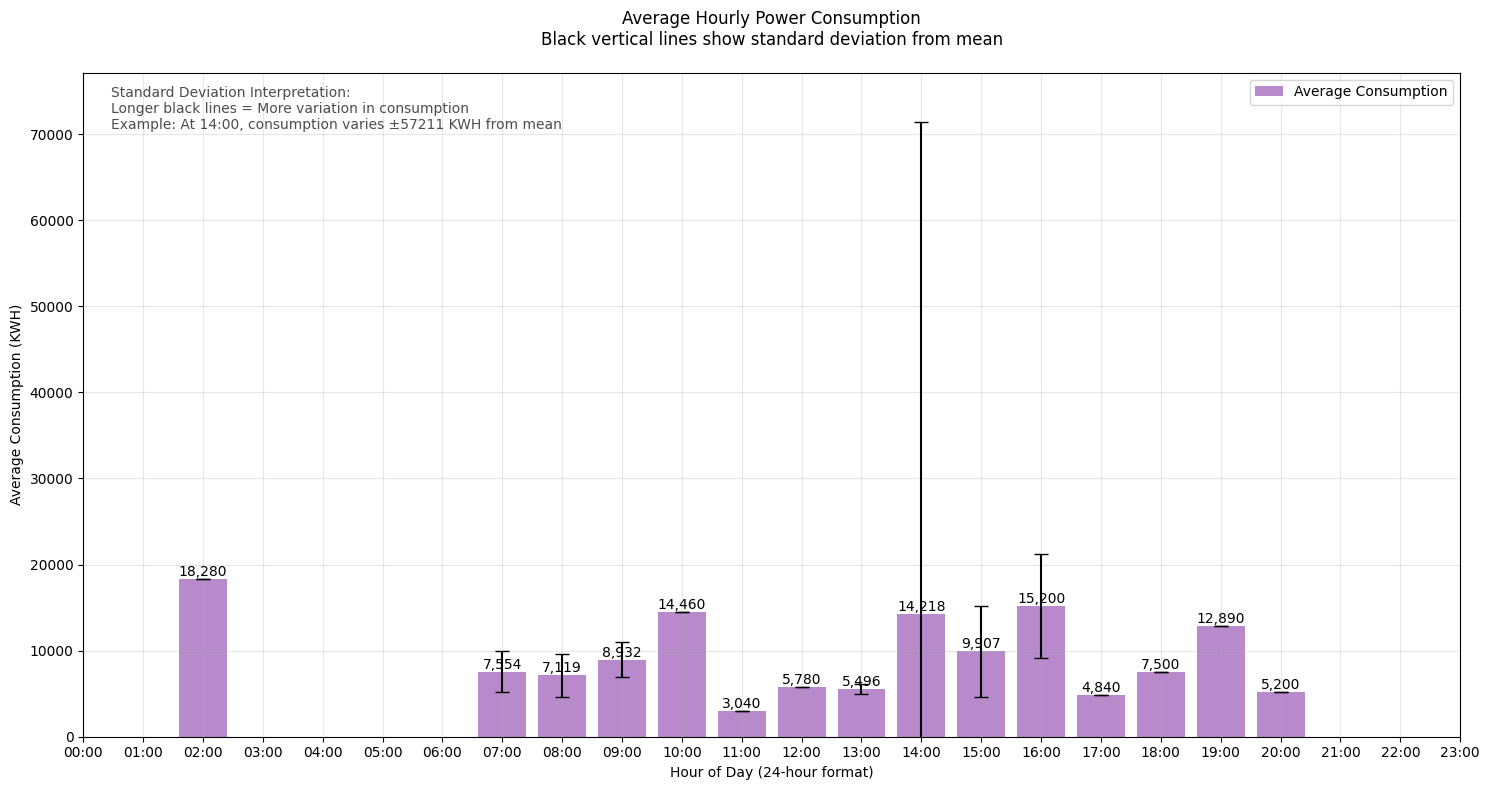

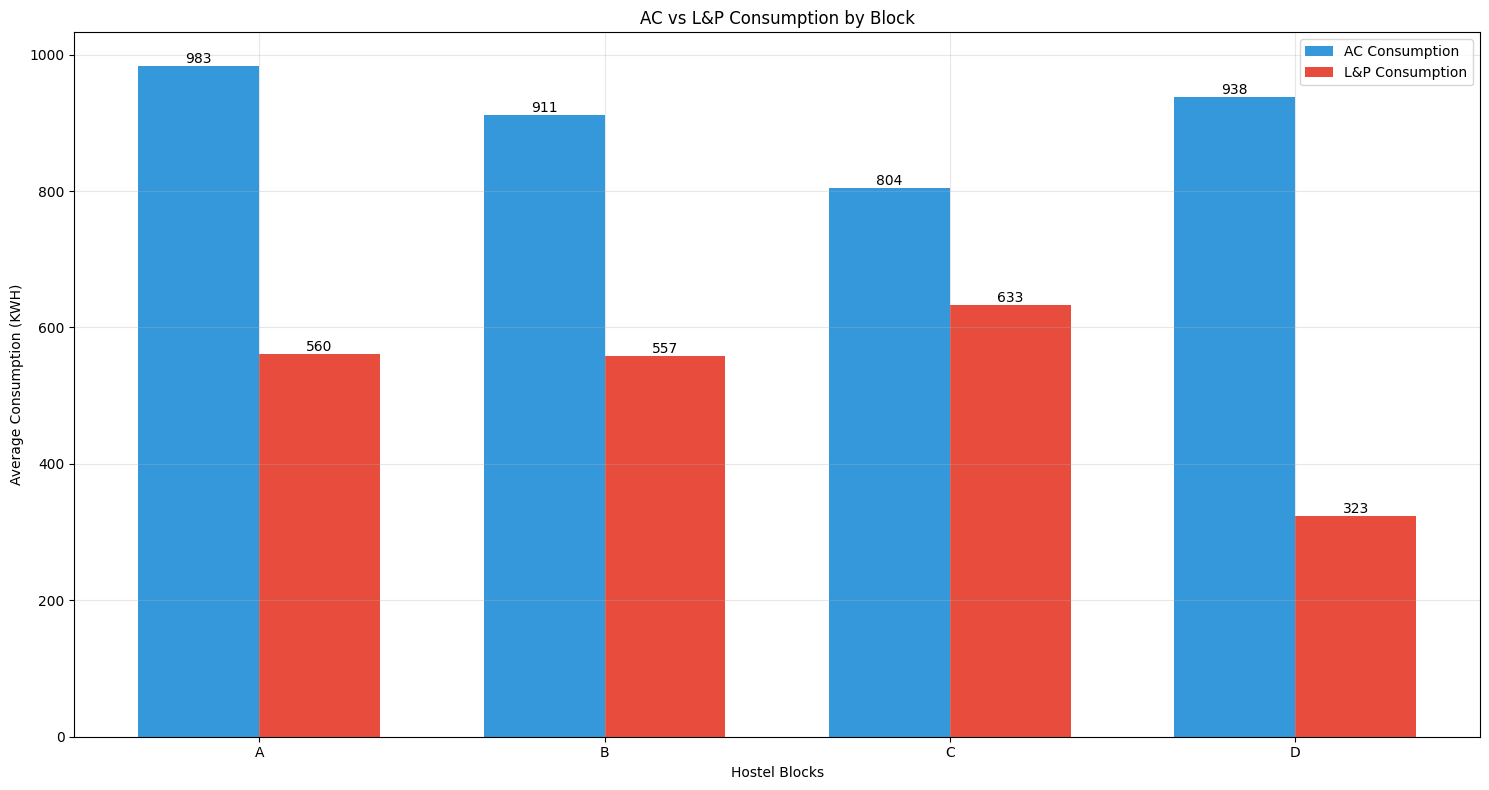

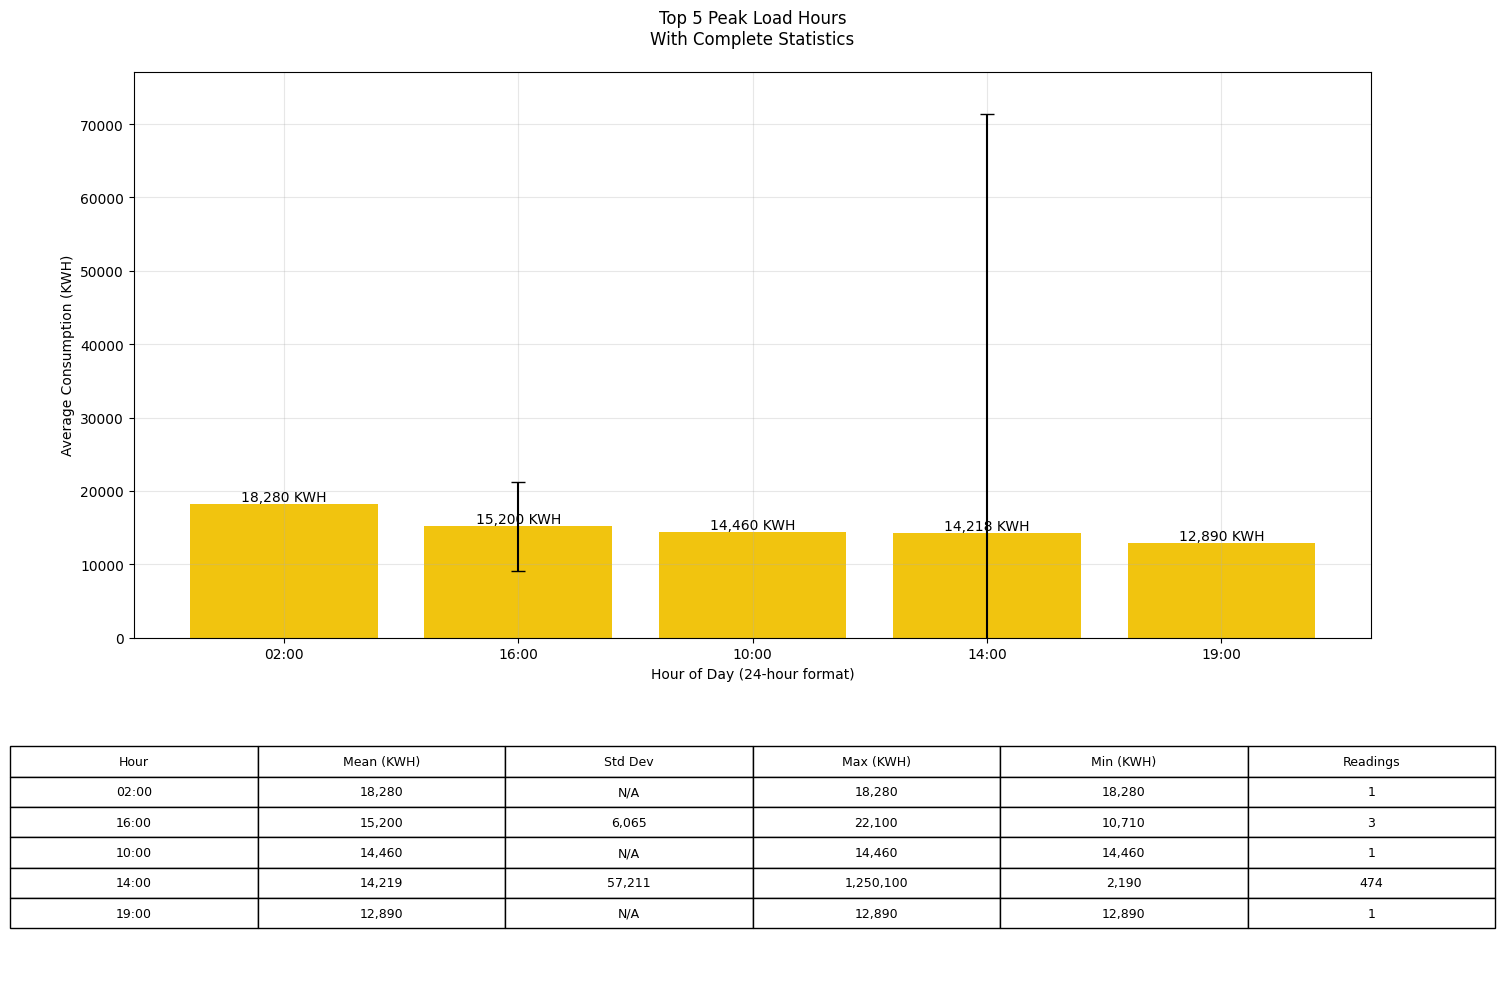


Analysis complete!


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import re

def extract_hour_from_string(time_str):
    """Extract hour from various time string formats"""
    if pd.isna(time_str):
        return None

    time_str = str(time_str).strip()
    time_pattern = r'(\d{1,2})[:.](\d{2})?\s*(?:PM|AM|pm|am)?[,\s]*(?:\d+)?[C\s]*'
    match = re.search(time_pattern, time_str)

    if match:
        hour = int(match.group(1))
        if 'PM' in time_str.upper() and hour != 12:
            hour += 12
        elif 'AM' in time_str.upper() and hour == 12:
            hour = 0
        return hour
    return None

def load_and_preprocess_data():
    """Load and preprocess the data with proper handling of columns"""
    try:
        # Read both datasets
        df_building = pd.read_csv('Sub No 5 Unit Consumption - Consumption Building Unit.csv', skiprows=0)
        df_substation = pd.read_csv('Sub No 5 Unit Consumption - Sheet2.csv', skiprows=0)

        print("Files loaded successfully. Processing data...")

        # Set proper column names from first row
        df_building.columns = df_building.iloc[0]
        df_substation.columns = df_substation.iloc[0]

        # Remove the header row and reset index
        df_building = df_building.iloc[1:].reset_index(drop=True)
        df_substation = df_substation.iloc[1:].reset_index(drop=True)

        # Convert date using mixed format
        print("Converting dates...")
        df_building['Date'] = pd.to_datetime(df_building['Date'], format='mixed', dayfirst=True)
        df_substation['Date'] = pd.to_datetime(df_substation['Date'], format='mixed', dayfirst=True)

        print("Extracting hours...")
        # Extract hours with validation
        df_building['Hour'] = df_building['Time & Temp'].apply(extract_hour_from_string)
        df_substation['Hour'] = df_substation['Time & Temp'].apply(extract_hour_from_string)

        # Filter valid hours
        df_building = df_building[df_building['Hour'].between(0, 23)]
        df_substation = df_substation[df_substation['Hour'].between(0, 23)]

        print("Converting numeric values...")
        # Convert consumption columns to numeric
        for df in [df_building, df_substation]:
            numeric_cols = [col for col in df.columns if any(x in str(col) for x in ['KWH', 'MWH', 'Unit'])]
            for col in numeric_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        print("Data preprocessing completed successfully!")
        return df_building, df_substation

    except Exception as e:
        print(f"Error in data processing: {str(e)}")
        import traceback
        print(traceback.format_exc())
        return None, None

def create_visualizations(df_building, df_substation):
    """Create comprehensive visualizations with value labels and no negative values"""
    plt.style.use('default')

    # 1. Hourly Pattern with Standard Deviation
    plt.figure(figsize=(15, 8))
    hourly_stats = df_substation.groupby('Hour')['Total Unit Consumed in KWH'].agg(['mean', 'std']).fillna(0)

    # Remove negative values by setting y-axis limit
    hourly_stats['mean'] = hourly_stats['mean'].clip(lower=0)

    bars = plt.bar(hourly_stats.index, hourly_stats['mean'],
           yerr=hourly_stats['std'], capsize=5,
           color='#9b59b6', alpha=0.7,
           label='Average Consumption')

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')

    plt.title('Average Hourly Power Consumption\nBlack vertical lines show standard deviation from mean',
             pad=20)
    plt.xlabel('Hour of Day (24-hour format)')
    plt.ylabel('Average Consumption (KWH)')
    plt.grid(True, alpha=0.3)
    plt.ylim(bottom=0)  # Ensure no negative values shown

    # Add explanation text
    std_14 = hourly_stats.loc[14, 'std'] if 14 in hourly_stats.index else 0
    stats_text = "Standard Deviation Interpretation:\n"
    stats_text += "Longer black lines = More variation in consumption\n"
    stats_text += f"Example: At 14:00, consumption varies ±{std_14:.0f} KWH from mean"
    plt.text(0.02, 0.98, stats_text,
            transform=plt.gca().transAxes, fontsize=10, alpha=0.7,
            verticalalignment='top')

    plt.xticks(range(0, 24), [f'{int(i):02d}:00' for i in range(0, 24)])
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Block-wise AC vs L&P Consumption Comparison
    plt.figure(figsize=(15, 8))
    ac_cols = [col for col in df_substation.columns if 'Block' in str(col) and 'AC' in str(col)]
    lp_cols = [col for col in df_substation.columns if 'Block' in str(col) and 'L&P' in str(col)]

    ac_data = df_substation[ac_cols].mean().clip(lower=0)
    lp_data = df_substation[lp_cols].mean().clip(lower=0)

    x = np.arange(len(ac_cols))
    width = 0.35

    # Create bars and add value labels
    ac_bars = plt.bar(x - width/2, ac_data, width, label='AC Consumption', color='#3498db')
    lp_bars = plt.bar(x + width/2, lp_data, width, label='L&P Consumption', color='#e74c3c')

    # Add value labels for AC consumption
    for bar in ac_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')

    # Add value labels for L&P consumption
    for bar in lp_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')

    plt.xlabel('Hostel Blocks')
    plt.ylabel('Average Consumption (KWH)')
    plt.title('AC vs L&P Consumption by Block')
    plt.xticks(x, [col.split('Block-')[1].split()[0] for col in ac_cols])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(bottom=0)  # Ensure no negative values shown
    plt.tight_layout()
    plt.show()

    # 3. Top 5 Peak Load Hours with Statistics
    stats = df_substation.groupby('Hour')['Total Unit Consumed in KWH'].agg([
        ('mean', lambda x: x.clip(lower=0).mean()),  # Remove negative values
        ('std', 'std'),
        ('max', 'max'),
        ('min', lambda x: x.clip(lower=0).min()),  # Remove negative values
        ('count', 'count')
    ])

    top_5_hours = stats.nlargest(5, 'mean')

    fig = plt.figure(figsize=(15, 10))
    gs = plt.GridSpec(2, 1, height_ratios=[2, 1])

    # Bar chart
    ax1 = fig.add_subplot(gs[0])
    bars = ax1.bar(range(len(top_5_hours)), top_5_hours['mean'],
                  yerr=top_5_hours['std'], capsize=5,
                  color='#f1c40f')

    # Add value labels
    for i, bar in enumerate(bars):
        height = top_5_hours['mean'].iloc[i]
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,} KWH',
                ha='center', va='bottom')

    ax1.set_xticks(range(len(top_5_hours)))
    ax1.set_xticklabels([f'{int(hour):02d}:00' for hour in top_5_hours.index])
    ax1.set_title('Top 5 Peak Load Hours\nWith Complete Statistics', pad=20)
    ax1.set_xlabel('Hour of Day (24-hour format)')
    ax1.set_ylabel('Average Consumption (KWH)')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)  # Ensure no negative values shown

    # Statistics table
    ax2 = fig.add_subplot(gs[1])
    cell_text = []
    for hour in top_5_hours.index:
        cell_text.append([
            f'{int(hour):02d}:00',
            f'{stats.loc[hour, "mean"]:,.0f}',
            f'{stats.loc[hour, "std"]:,.0f}' if pd.notna(stats.loc[hour, "std"]) else 'N/A',
            f'{stats.loc[hour, "max"]:,.0f}',
            f'{stats.loc[hour, "min"]:,.0f}',
            f'{stats.loc[hour, "count"]}'
        ])

    table = ax2.table(
        cellText=cell_text,
        colLabels=['Hour', 'Mean (KWH)', 'Std Dev', 'Max (KWH)', 'Min (KWH)', 'Readings'],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()
def main():
    print("Loading and preprocessing data...")
    df_building, df_substation = load_and_preprocess_data()

    if df_building is None or df_substation is None:
        print("Error: Could not process data")
        return

    print("\nGenerating visualizations and analysis...")
    create_visualizations(df_building, df_substation)

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()

Loading and preprocessing data...
Successfully loaded Building Unit data
Building Unit columns: ['  ', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32']
Successfully loaded Sheet2 data
Sheet2 columns: ['Unit Consumption at Substation No-05 Outgoing Feeder', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 

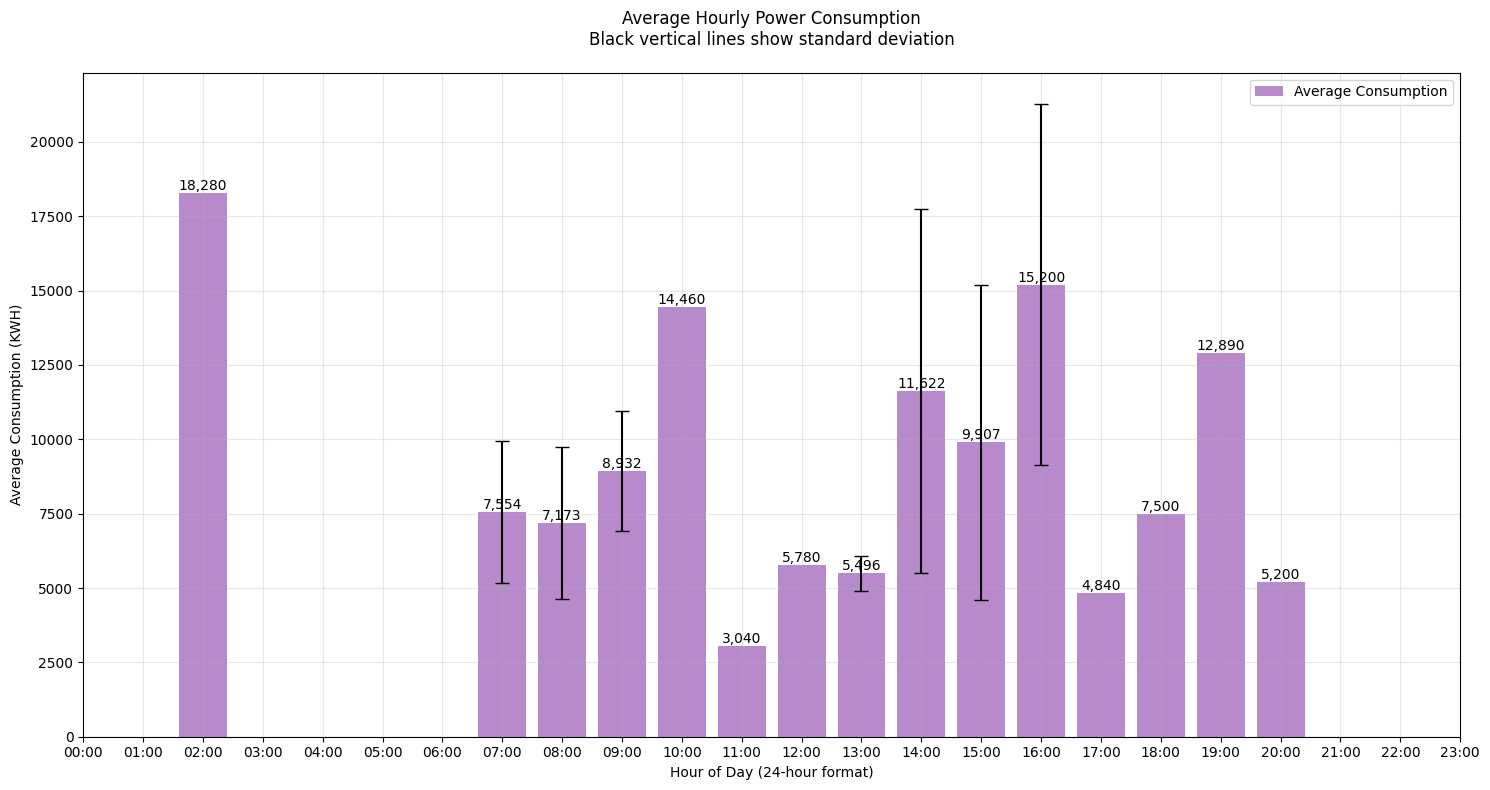

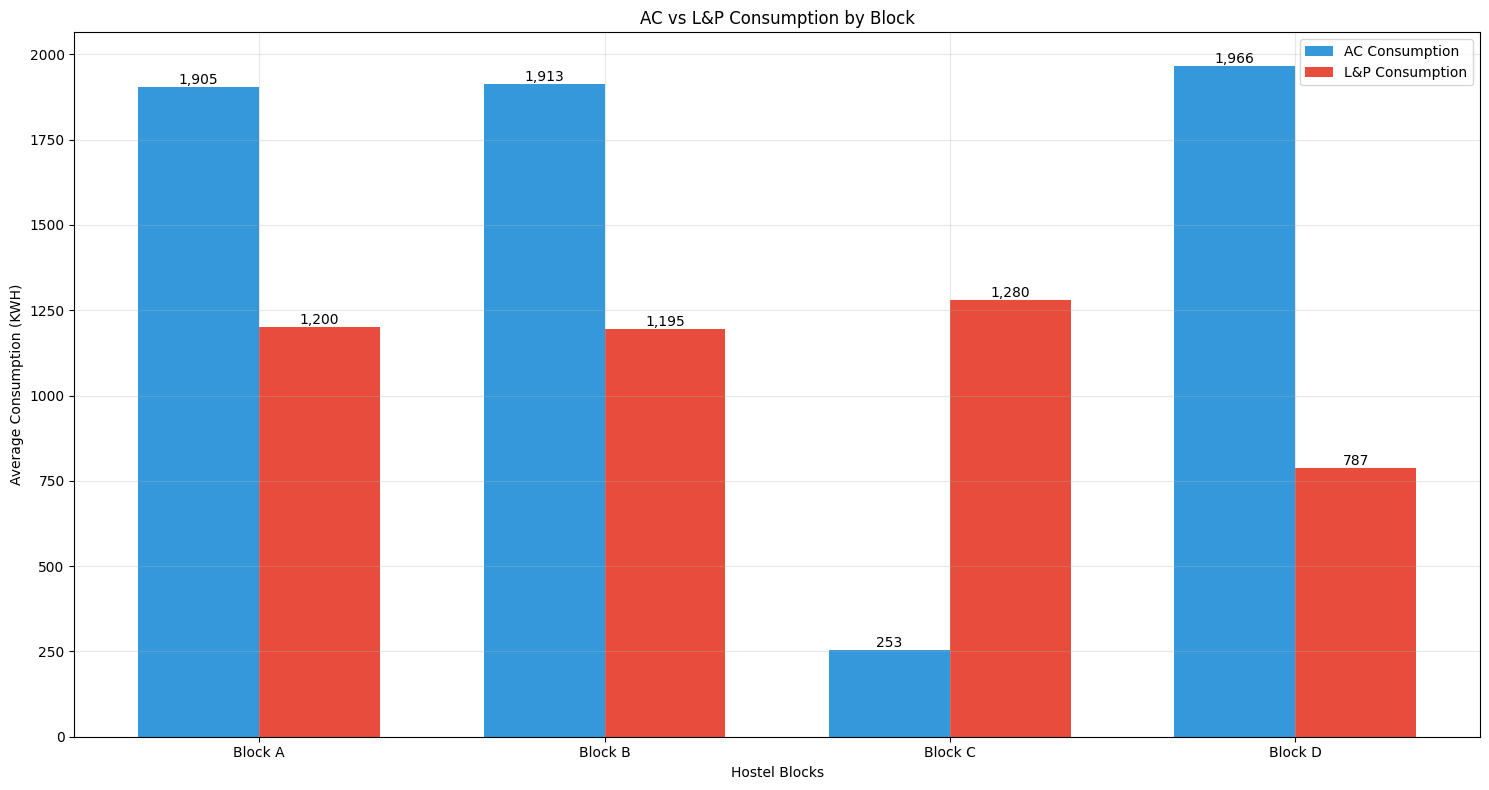


Analyzing peak hours...


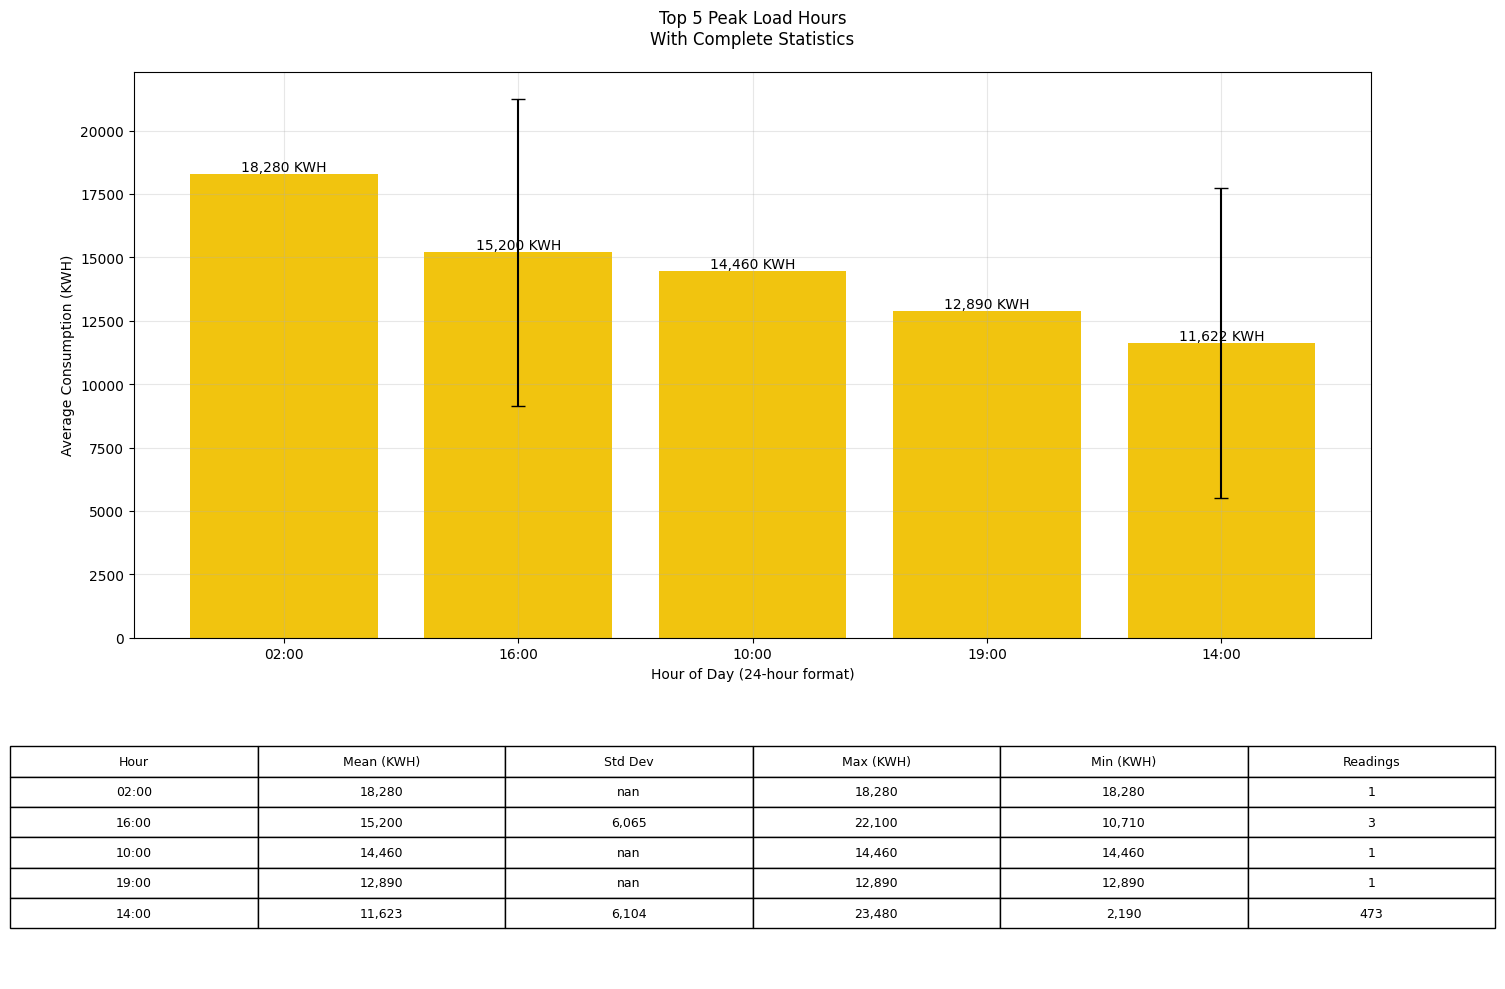


Top 5 Peak Consumption Hours:

02:00 Statistics:
  Average: 18,280.00 KWH
  Std Dev: nan KWH
  Maximum: 18,280.00 KWH
  Minimum: 18,280.00 KWH
  Readings: 1

16:00 Statistics:
  Average: 15,200.00 KWH
  Std Dev: 6,065.40 KWH
  Maximum: 22,100.00 KWH
  Minimum: 10,710.00 KWH
  Readings: 3

10:00 Statistics:
  Average: 14,460.00 KWH
  Std Dev: nan KWH
  Maximum: 14,460.00 KWH
  Minimum: 14,460.00 KWH
  Readings: 1

19:00 Statistics:
  Average: 12,890.00 KWH
  Std Dev: nan KWH
  Maximum: 12,890.00 KWH
  Minimum: 12,890.00 KWH
  Readings: 1

14:00 Statistics:
  Average: 11,622.51 KWH
  Std Dev: 6,103.93 KWH
  Maximum: 23,480.00 KWH
  Minimum: 2,190.00 KWH
  Readings: 473

Generating monthly trend visualizations...


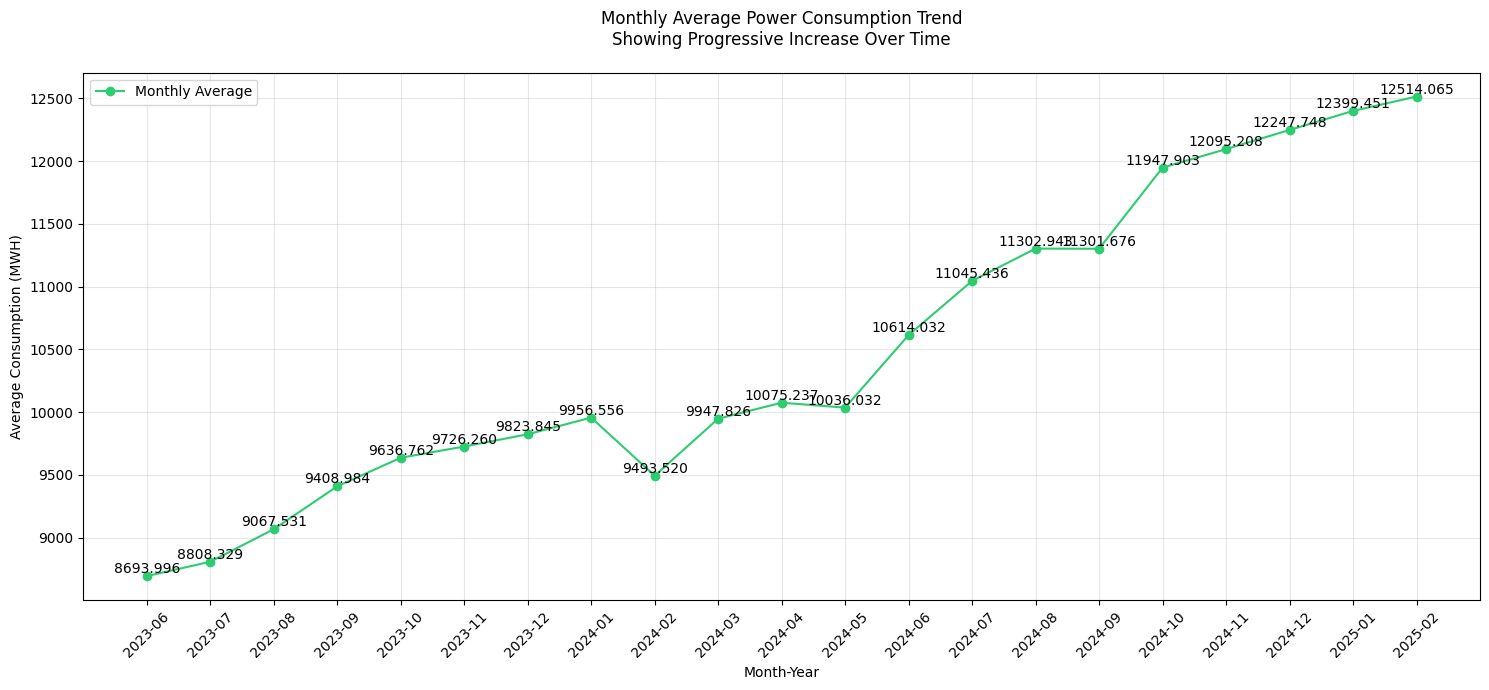

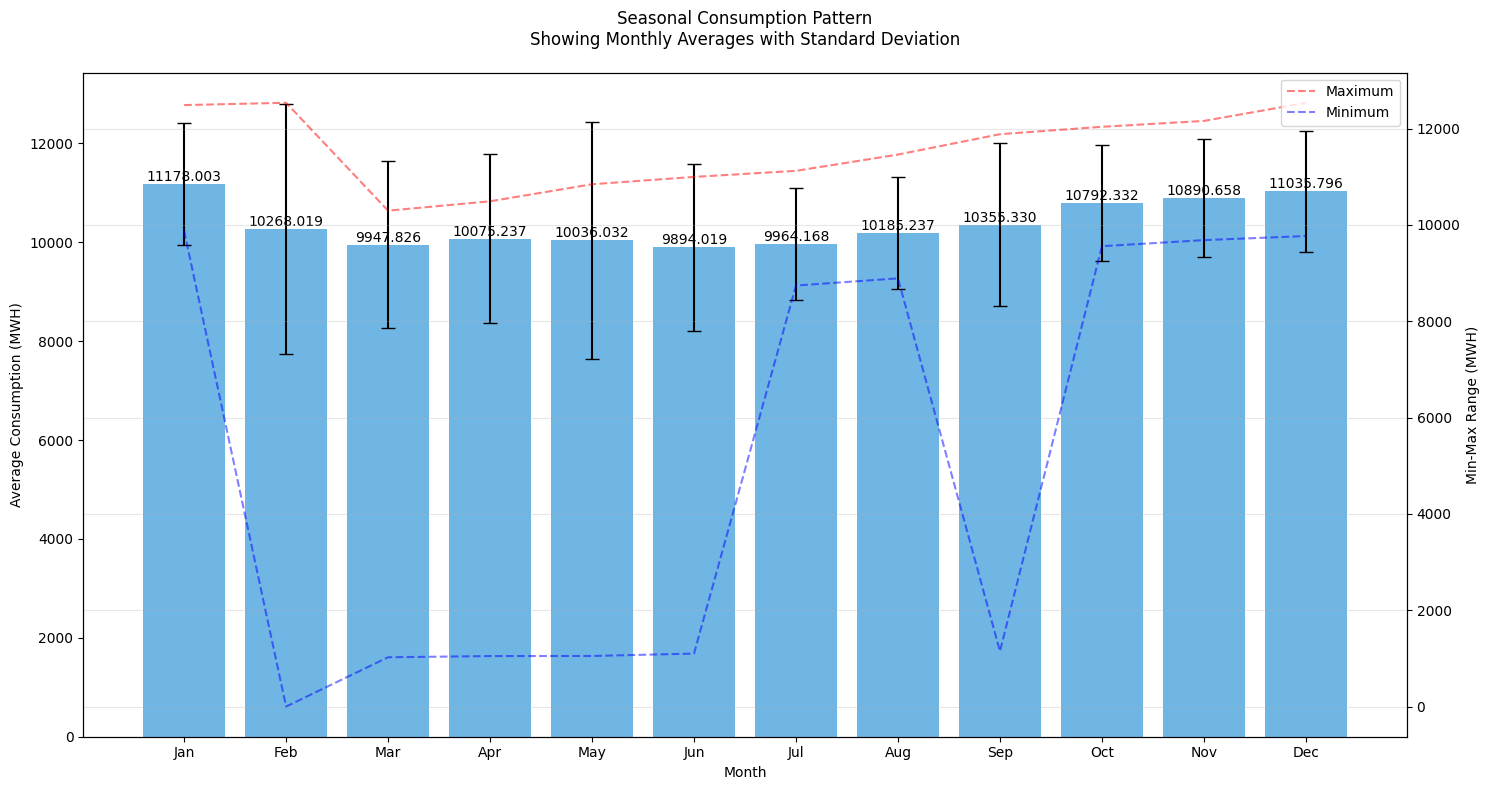


Monthly Consumption Statistics:

January:
  Average: 11,178.00 MWH
  Minimum: 9,876.85 MWH
  Maximum: 12,487.84 MWH

February:
  Average: 10,268.02 MWH
  Minimum: 0.00 MWH
  Maximum: 12,536.09 MWH
  Month-over-Month Change: -8.1%

March:
  Average: 9,947.83 MWH
  Minimum: 1,023.06 MWH
  Maximum: 10,295.67 MWH
  Month-over-Month Change: -3.1%

April:
  Average: 10,075.24 MWH
  Minimum: 1,047.96 MWH
  Maximum: 10,490.50 MWH
  Month-over-Month Change: +1.3%

May:
  Average: 10,036.03 MWH
  Minimum: 1,049.81 MWH
  Maximum: 10,844.24 MWH
  Month-over-Month Change: -0.4%

June:
  Average: 9,894.02 MWH
  Minimum: 1,099.21 MWH
  Maximum: 10,996.48 MWH
  Month-over-Month Change: -1.4%

July:
  Average: 9,964.17 MWH
  Minimum: 8,741.29 MWH
  Maximum: 11,122.91 MWH
  Month-over-Month Change: +0.7%

August:
  Average: 10,185.24 MWH
  Minimum: 8,889.97 MWH
  Maximum: 11,460.68 MWH
  Month-over-Month Change: +2.2%

September:
  Average: 10,355.33 MWH
  Minimum: 1,147.58 MWH
  Maximum: 11,883.52 MWH

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import re

def extract_hour_from_string(time_str):
    """Extract hour from various time string formats"""
    if pd.isna(time_str):
        return None

    time_str = str(time_str).strip()
    time_pattern = r'(\d{1,2})[:.](\d{2})?\s*(?:PM|AM|pm|am)?[,\s]*(?:\d+)?[C\s]*'
    match = re.search(time_pattern, time_str)

    if match:
        hour = int(match.group(1))
        if 'PM' in time_str.upper() and hour != 12:
            hour += 12
        elif 'AM' in time_str.upper() and hour == 12:
            hour = 0
        return hour
    return None

def load_and_preprocess_data():
    try:
        # Read both datasets with their exact names
        df_building = pd.read_csv('Sub No 5 Unit Consumption - Consumption Building Unit.csv')
        print("Successfully loaded Building Unit data")
        print("Building Unit columns:", df_building.columns.tolist())

        df_substation = pd.read_csv('Sub No 5 Unit Consumption - Sheet2.csv')
        print("Successfully loaded Sheet2 data")
        print("Sheet2 columns:", df_substation.columns.tolist())

        # First, look at the first few rows to understand structure
        print("\nFirst few rows of Building Unit data:")
        print(df_building.head())
        print("\nFirst few rows of Sheet2 data:")
        print(df_substation.head())

        # Clean and preprocess Building Unit data
        # Assuming first row contains actual column names
        df_building.columns = df_building.iloc[0]
        df_building = df_building.iloc[1:].reset_index(drop=True)

        # Similarly for substation data
        df_substation.columns = df_substation.iloc[0]
        df_substation = df_substation.iloc[1:].reset_index(drop=True)

        # Convert dates using mixed format
        df_building['Date'] = pd.to_datetime(df_building['Date'], format='mixed', dayfirst=True)
        df_substation['Date'] = pd.to_datetime(df_substation['Date'], format='mixed', dayfirst=True)

        # Extract hours
        df_building['Hour'] = df_building['Time & Temp'].apply(extract_hour_from_string)
        df_substation['Hour'] = df_substation['Time & Temp'].apply(extract_hour_from_string)

        # Filter valid hours
        df_building = df_building[df_building['Hour'].between(0, 23)]
        df_substation = df_substation[df_substation['Hour'].between(0, 23)]

        # Convert numeric columns
        def convert_numeric_cols(df):
            for col in df.columns:
                if any(x in str(col) for x in ['KWH', 'MWH', 'Unit', 'Voltage', 'Current']):
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            return df

        df_building = convert_numeric_cols(df_building)
        df_substation = convert_numeric_cols(df_substation)

        print("Successfully preprocessed data")
        return df_building, df_substation

    except Exception as e:
        print(f"Error in data processing: {str(e)}")
        import traceback
        print(traceback.format_exc())
        return None, None

def create_visualizations(df_building, df_substation):
    """Create visualizations with no negative values"""
    try:
        plt.style.use('default')

        # 1. Hourly Consumption Pattern
        # First identify the consumption column from actual data
        consumption_col = [col for col in df_building.columns
                         if 'Unit' in str(col) and 'KWH' in str(col)][0]

        # Calculate statistics separately to avoid nested renamer error
        valid_data = df_building[df_building[consumption_col] >= 0]  # Filter negative values
        hourly_mean = valid_data.groupby('Hour')[consumption_col].mean()
        hourly_std = valid_data.groupby('Hour')[consumption_col].std()

        plt.figure(figsize=(15, 8))
        bars = plt.bar(hourly_mean.index, hourly_mean,
                      yerr=hourly_std, capsize=5,
                      color='#9b59b6', alpha=0.7,
                      label='Average Consumption')

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom')

        plt.title('Average Hourly Power Consumption\nBlack vertical lines show standard deviation',
                 pad=20)
        plt.xlabel('Hour of Day (24-hour format)')
        plt.ylabel('Average Consumption (KWH)')
        plt.grid(True, alpha=0.3)
        plt.ylim(bottom=0)  # Ensure y-axis starts at 0
        plt.xticks(range(0, 24), [f'{int(i):02d}:00' for i in range(0, 24)])
        plt.legend()
        plt.tight_layout()
        plt.show()

        # 2. AC vs L&P Block Comparison
        ac_cols = [col for col in df_building.columns if 'Block' in str(col) and 'AC' in str(col)]
        lp_cols = [col for col in df_building.columns if 'Block' in str(col) and 'L&P' in str(col)]

        # Filter negative values and calculate means
        ac_data = df_building[ac_cols].clip(lower=0).mean()
        lp_data = df_building[lp_cols].clip(lower=0).mean()

        plt.figure(figsize=(15, 8))
        x = np.arange(len(ac_cols))
        width = 0.35

        ac_bars = plt.bar(x - width/2, ac_data, width, label='AC Consumption', color='#3498db')
        lp_bars = plt.bar(x + width/2, lp_data, width, label='L&P Consumption', color='#e74c3c')

        # Add value labels
        def add_labels(bars):
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height):,}',
                        ha='center', va='bottom')

        add_labels(ac_bars)
        add_labels(lp_bars)

        plt.title('AC vs L&P Consumption by Block')
        plt.xlabel('Hostel Blocks')
        plt.ylabel('Average Consumption (KWH)')
        plt.xticks(x, [f'Block {chr(65+i)}' for i in range(len(ac_cols))])
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(bottom=0)  # Ensure y-axis starts at 0
        plt.tight_layout()
        plt.show()

        # 3. Top 5 Peak Hours Analysis
        print("\nAnalyzing peak hours...")
        # Calculate statistics separately
        valid_hours = valid_data.groupby('Hour')

        hourly_mean = valid_hours[consumption_col].mean()
        hourly_std = valid_hours[consumption_col].std()
        hourly_max = valid_hours[consumption_col].max()
        hourly_min = valid_hours[consumption_col].min()
        hourly_count = valid_hours[consumption_col].count()

        # Get top 5 hours
        top_hours = hourly_mean.nlargest(5)

        # Create visualization
        plt.figure(figsize=(15, 10))
        gs = plt.GridSpec(2, 1, height_ratios=[2, 1])

        # Bar chart
        ax1 = plt.subplot(gs[0])
        bars = ax1.bar(range(len(top_hours)), top_hours.values,
                      yerr=[hourly_std[hour] for hour in top_hours.index],
                      capsize=5, color='#f1c40f')

        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,} KWH',
                    ha='center', va='bottom')

        ax1.set_title('Top 5 Peak Load Hours\nWith Complete Statistics', pad=20)
        ax1.set_xlabel('Hour of Day (24-hour format)')
        ax1.set_ylabel('Average Consumption (KWH)')
        ax1.set_xticks(range(len(top_hours)))
        ax1.set_xticklabels([f'{int(hour):02d}:00' for hour in top_hours.index])
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(bottom=0)

        # Statistics table
        ax2 = plt.subplot(gs[1])
        cell_text = []
        for hour in top_hours.index:
            cell_text.append([
                f'{int(hour):02d}:00',
                f'{hourly_mean[hour]:,.0f}',
                f'{hourly_std[hour]:,.0f}',
                f'{hourly_max[hour]:,.0f}',
                f'{hourly_min[hour]:,.0f}',
                f'{hourly_count[hour]}'
            ])

        table = ax2.table(
            cellText=cell_text,
            colLabels=['Hour', 'Mean (KWH)', 'Std Dev', 'Max (KWH)', 'Min (KWH)', 'Readings'],
            loc='center',
            cellLoc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        # Print peak hours summary
        print("\nTop 5 Peak Consumption Hours:")
        for hour in top_hours.index:
            print(f"\n{int(hour):02d}:00 Statistics:")
            print(f"  Average: {hourly_mean[hour]:,.2f} KWH")
            print(f"  Std Dev: {hourly_std[hour]:,.2f} KWH")
            print(f"  Maximum: {hourly_max[hour]:,.2f} KWH")
            print(f"  Minimum: {hourly_min[hour]:,.2f} KWH")
            print(f"  Readings: {hourly_count[hour]}")

    except Exception as e:
        print(f"Error in visualizations: {str(e)}")
        import traceback
        print(traceback.format_exc())

def create_monthly_visualizations(df_building, df_substation):
    """Create monthly trend visualizations"""
    try:
        # Add month and year columns
        df_building['Month'] = df_building['Date'].dt.month
        df_building['Year'] = df_building['Date'].dt.year
        df_building['MonthYear'] = df_building['Date'].dt.to_period('M')

        # 1. Monthly Average Consumption Trend
        plt.figure(figsize=(15, 7))

        # Calculate monthly averages
        monthly_avg = df_building.groupby('MonthYear')['TR-1 KWH'].mean() / 1000  # Convert to MWH

        # Create the line plot
        plt.plot(range(len(monthly_avg)), monthly_avg.values,
                marker='o', linestyle='-', color='#2ecc71',
                label='Monthly Average')

        # Add value labels
        for i, value in enumerate(monthly_avg.values):
            plt.text(i, value, f'{value:.3f}',
                    ha='center', va='bottom')

        plt.title('Monthly Average Power Consumption Trend\nShowing Progressive Increase Over Time',
                 pad=20)
        plt.xlabel('Month-Year')
        plt.ylabel('Average Consumption (MWH)')
        plt.grid(True, alpha=0.3)
        plt.xticks(range(len(monthly_avg)),
                  [str(date) for date in monthly_avg.index],
                  rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # 2. Seasonal Pattern Analysis
        plt.figure(figsize=(15, 8))

        # Calculate monthly statistics
        monthly_stats = df_building.groupby('Month')['TR-1 KWH'].agg(['mean', 'std', 'min', 'max'])
        monthly_stats['mean'] = monthly_stats['mean'] / 1000  # Convert to MWH
        monthly_stats['min'] = monthly_stats['min'] / 1000
        monthly_stats['max'] = monthly_stats['max'] / 1000

        # Create bar plot with error bars
        bars = plt.bar(range(1, 13), monthly_stats['mean'],
                      yerr=monthly_stats['std'] / 1000,
                      capsize=5,
                      color='#3498db',
                      alpha=0.7)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')

        # Add min-max lines
        ax = plt.gca()
        ax2 = ax.twinx()
        ax2.plot(range(1, 13), monthly_stats['max'], 'r--', alpha=0.5, label='Maximum')
        ax2.plot(range(1, 13), monthly_stats['min'], 'b--', alpha=0.5, label='Minimum')

        # Set titles and labels
        plt.title('Seasonal Consumption Pattern\nShowing Monthly Averages with Standard Deviation',
                 pad=20)
        ax.set_xlabel('Month')
        ax.set_ylabel('Average Consumption (MWH)')
        ax2.set_ylabel('Min-Max Range (MWH)')

        # Set x-axis labels
        plt.xticks(range(1, 13),
                  ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

        # Combine legends
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print monthly statistics
        print("\nMonthly Consumption Statistics:")
        months = ['January', 'February', 'March', 'April', 'May', 'June',
                 'July', 'August', 'September', 'October', 'November', 'December']

        for month in range(1, 13):
            if month in monthly_stats.index:
                print(f"\n{months[month-1]}:")
                print(f"  Average: {monthly_stats.loc[month, 'mean']:,.2f} MWH")
                print(f"  Minimum: {monthly_stats.loc[month, 'min']:,.2f} MWH")
                print(f"  Maximum: {monthly_stats.loc[month, 'max']:,.2f} MWH")
                if month > 1:
                    change = ((monthly_stats.loc[month, 'mean'] /
                             monthly_stats.loc[month-1, 'mean'] - 1) * 100)
                    print(f"  Month-over-Month Change: {change:+.1f}%")

    except Exception as e:
        print(f"Error in monthly visualizations: {str(e)}")
        import traceback
        print(traceback.format_exc())

def main():
    print("Loading and preprocessing data...")
    df_building, df_substation = load_and_preprocess_data()

    if df_building is None or df_substation is None:
        print("Error: Could not process data")
        return

    print("\nGenerating hourly and block-wise visualizations...")
    create_visualizations(df_building, df_substation)

    print("\nGenerating monthly trend visualizations...")
    create_monthly_visualizations(df_building, df_substation)

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()